In [47]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('tesla.csv')
data.head()

,Date,Open,High,Low,Close,Volume,Adj Close
0,6/29/2010,19.000000,25.00,17.540001,23.889999,18766300,23.889999
1,6/30/2010,25.790001,30.42,23.299999,23.830000,17187100,23.830000
2,7/1/2010,25.000000,25.92,20.270000,21.959999,8218800,21.959999
3,7/2/2010,23.000000,23.10,18.709999,19.200001,5139800,19.200001
4,7/6/2010,20.000000,20.00,15.830000,16.110001,6866900,16.110001


In [4]:
df = pd.DataFrame()
df['Date'] = pd.to_datetime(data['Date'])
df['Values'] = data['Open']
df.set_index('Date', inplace=True)
df.head()

,Values
Date,
2010-06-29,19.000000
2010-06-30,25.790001
2010-07-01,25.000000
2010-07-02,23.000000
2010-07-06,20.000000


In [5]:
df.tail()

,Values
Date,
2017-03-13,244.820007
2017-03-14,246.110001
2017-03-15,257.000000
2017-03-16,262.399994
2017-03-17,264.000000


In [6]:
df.isna().sum()

Values    0
dtype: int64

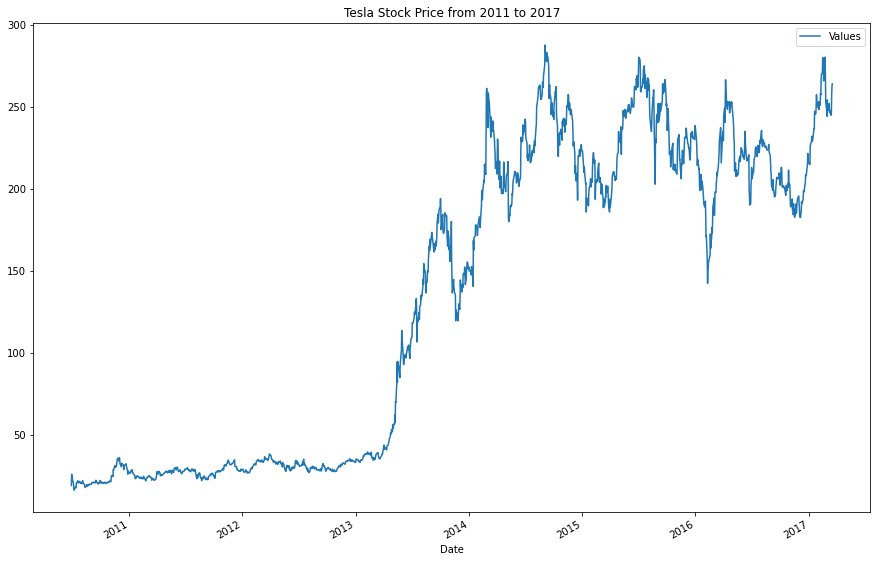

In [7]:
df.plot(figsize=(15, 10), kind='line')
pt.title("Tesla Stock Price from 2011 to 2017");
pt.show()

## Seasonality Decompostion

**Dickey Fuller Test**:                                                                                                           
The Dickey Fuller test is a common statistical test used to test whether a given Time series is stationary or not. The Augmented Dickey Fuller (ADF) test expands the Dickey-Fuller test equation to include high order regressive process in the model. We can implement the ADF test via the adfuller() function. It returns the following outputs:

In [8]:
def dickeyFuller(df, target):
    
    # Dickey Fuller Test
    X = df.values
    result = adfuller(X)
    print("ADF Statistic test:", result[0])
    print('P - value: ', result[1])
    print('Number of lags used: ', result[2])
    print('Critical Values: ')
    for key, value in result[4].items():
        print('\t%s : %.3f' % (key, value))
              
    # Decompostion Seasonility if exists
    if result[0] > 0:
        df[target] = df[target].rolling(12).mean()
    
    return df

In [9]:
df = dickeyFuller(df, target='Value')

ADF Statistic test: -0.8181928810104876
P - value:  0.8137195490650424
Number of lags used:  1
Critical Values: 
	1% : -3.434
	5% : -2.863
	10% : -2.568


## Autocorrelation Plot

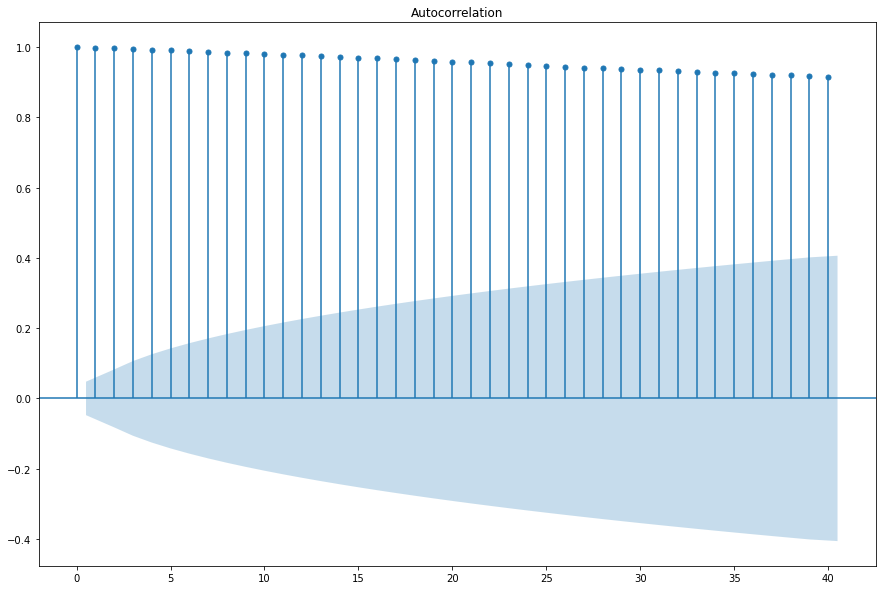

In [10]:
x = plot_acf(df, lags=40)
x.set_size_inches(15, 10, forward=True)
pt.show()

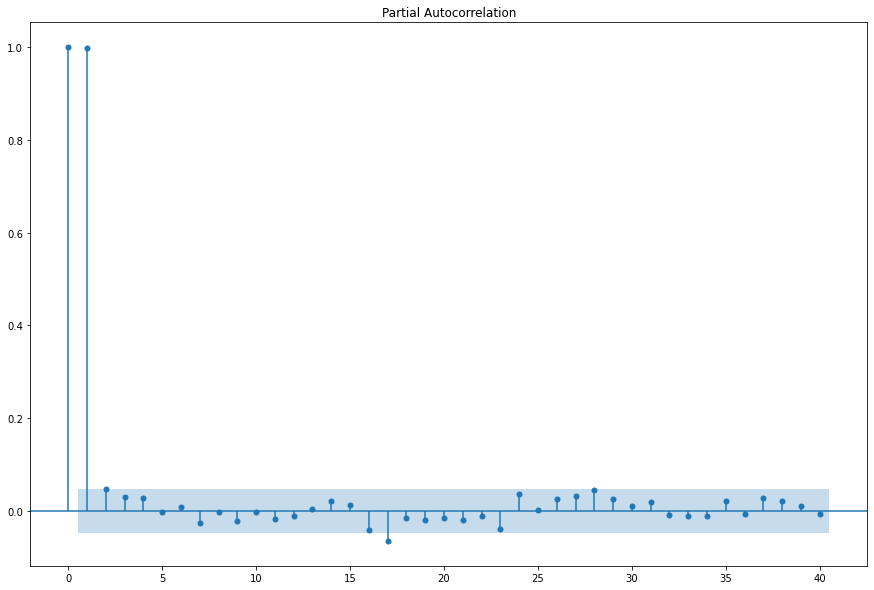

In [11]:
y = plot_pacf(df, lags=40)
y.set_size_inches(15, 10, forward=True)
pt.show()

In [12]:
size = int(len(df)*0.9)
df_train, df_test = df.iloc[:size], df.iloc[size:]

In [13]:
len(df_train)

1522

In [14]:
df_train.tail()

,Values
Date,
2016-07-08,217.800003
2016-07-11,219.960007
2016-07-12,224.100006
2016-07-13,225.500000
2016-07-14,223.119995


## Model Auto Regressive Integrated Moving Average (ARIMA)

In [15]:
model = ARIMA(df_train, order=(1, 1, 1))
result = model.fit()

In [59]:
d = df.drop('Values', axis = 1)

start_date = pd.to_datetime(d.iloc[size].name)
end_date = pd.to_datetime(d.iloc[len(df)-1].name)
start_date, end_date

(Timestamp('2016-07-15 00:00:00'), Timestamp('2017-03-17 00:00:00'))

In [17]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.Values   No. Observations:                 1521
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -4518.698
Method:                       css-mle   S.D. of innovations              4.721
Date:                Mon, 01 Nov 2021   AIC                           9045.395
Time:                        19:51:20   BIC                           9066.704
Sample:                             1   HQIC                          9053.328
                                                                              
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.1339      0.111      1.208      0.227      -0.083       0.351
ar.L1.D.Values     0.4682      0.327      1.430      0.153      -0.174       1.110
ma.L1.D.Values    -0.5127      0.318     -1.613      0.107      -1.136       0.110
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.1360           +0.0000j            2.1360            0.0000
MA.1            1.9504           +0.0000j            1.9504            0.0000
-----------------------------------------------------------------------------
"""

In [85]:
start = pd.to_datetime(['2016-07-15'])
end = pd.to_datetime(['2017-03-17'])
start, end

(DatetimeIndex(['2016-07-15'], dtype='datetime64[ns]', freq=None),
 DatetimeIndex(['2017-03-17'], dtype='datetime64[ns]', freq=None))

In [86]:
df_pred = result.predict(start=start, end=end)
df_pred.head()

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [83]:
df_test.tail()

,Values
Date,
2017-03-13,244.820007
2017-03-14,246.110001
2017-03-15,257.000000
2017-03-16,262.399994
2017-03-17,264.000000


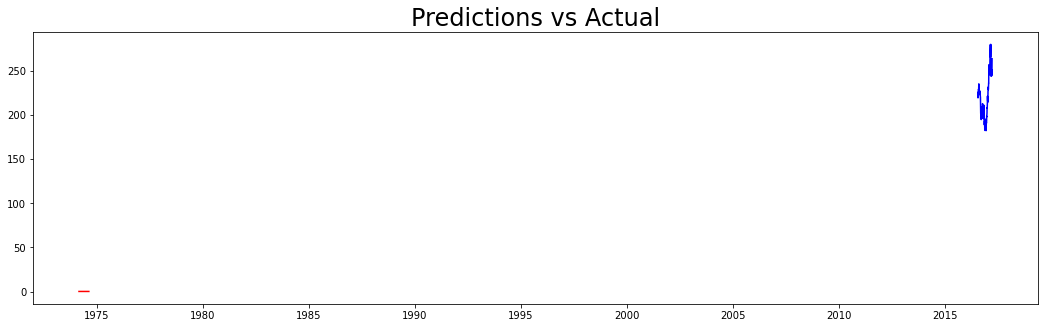

In [77]:
plt.figure(figsize=(18,5))
plt.plot(df_pred, color = "red")
plt.plot(df_test, color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.plot(fontsize="x-large")

plt.show()

<AxesSubplot:xlabel='Date'>

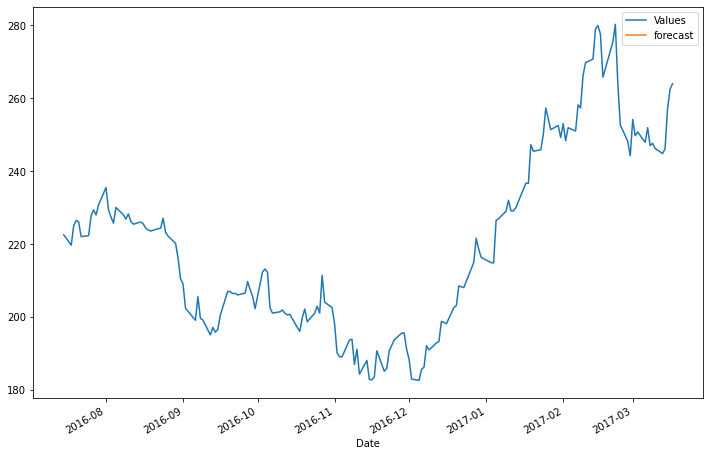

In [88]:
df_test['forecast'] = result.predict(start=size, end=len(df)-1, dynamic=True)
df_test[['Values','forecast']].plot(figsize=(12,8))

In [89]:
test = df_test['Values']
print("Mean Absolute Error {:.2f}".format(mean_absolute_error(test,df_pred)))
print("Mean Squared Error {:.2f}".format(mean_squared_error(test,df_pred)))
print("Root Mean Squared Error {:.2f}".format(np.sqrt(mean_squared_error(test,df_pred))))

ValueError: Found input variables with inconsistent numbers of samples: [170, 171]

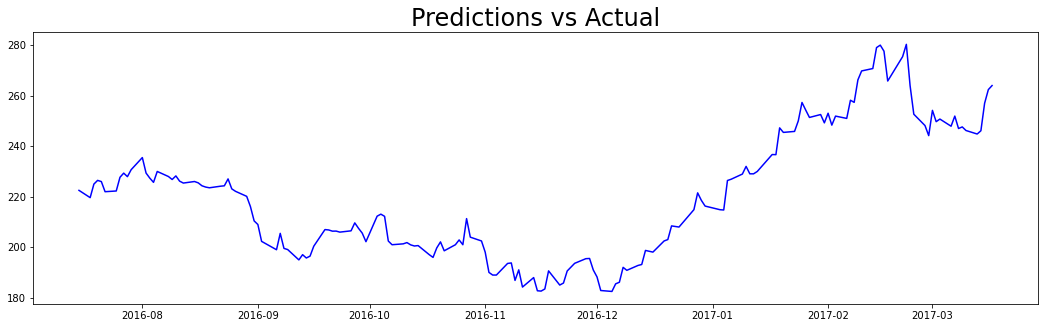

In [49]:
plt.figure(figsize=(18,5))
plt.plot(df_pred[size:len(df)-1], color = "red")
plt.plot(df_test, color = "blue")
plt.title("Predictions vs Actual", size = 24)
plt.plot(fontsize="x-large")
plt.show()

<AxesSubplot:>

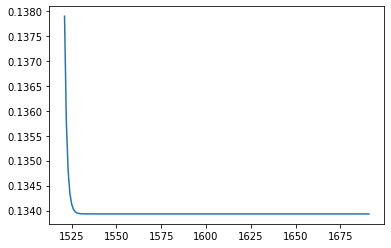

In [91]:
df_pred.plot()